In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from Models import LSTM
import time
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [2]:
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# Importing local modules (statistical distance measures)
from CVM_Distance import CVM_Dist as Cramer_Von_Mises_Dist
from Anderson_Darling_Distance import Anderson_Darling_Dist
from Kolmogorov_Smirnov_Distance import Kolmogorov_Smirnov_Dist
from KuiperDistance import Kuiper_Dist
from WassersteinDistance import Wasserstein_Dist
from DTS_Distance import DTS_Dist # Combo of Anderson_Darling and CVM distance.

Load and Prepare data to input to LSTM model

In [3]:
filepath = "RELIANCE_2010-01-012021-08-30.csv"
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2010-01-04,1091.1,1091.1,1021.85,1075.50,17520006,RELIANCE
1,2010-01-05,1149.9,1149.9,1065.40,1070.70,4890040,RELIANCE
2,2010-01-06,1079.9,1094.5,1070.65,1088.00,5415538,RELIANCE
3,2010-01-07,1088.0,1115.0,1078.00,1106.05,5988404,RELIANCE
4,2010-01-08,1108.0,1113.8,1096.00,1103.15,3453926,RELIANCE


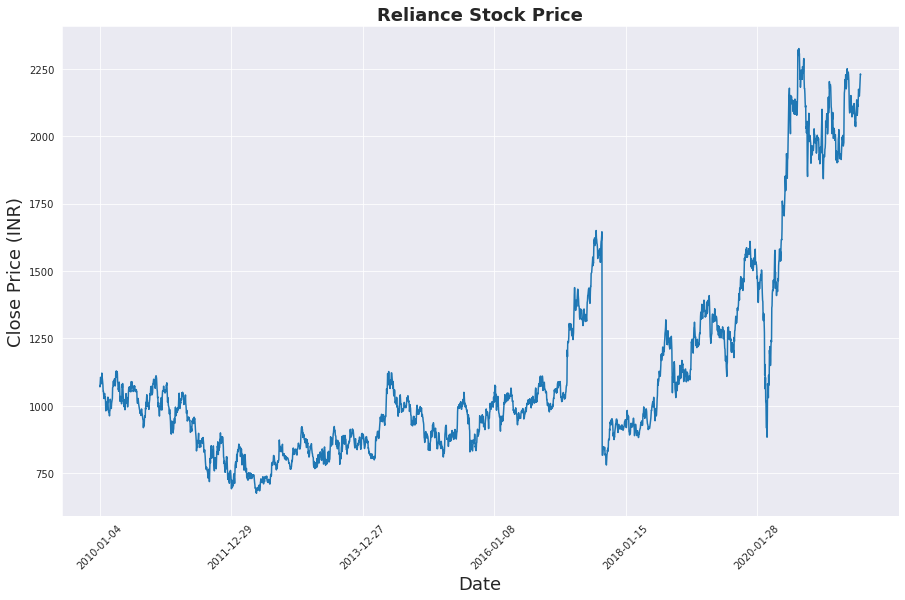

In [4]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title("Reliance Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (INR)',fontsize=18)
plt.show()

In [5]:
price = data[['Close']]

In [6]:
def splitData(ts):

    test_set_size = int(np.round(0.2*len(ts)));
    train_set = ts[:-test_set_size]    
    test_set = ts[-test_set_size:]

    return train_set, test_set


In [7]:
def modify_test_data(test_set, variance):
    
    noise = np.random.normal(0,variance,len(test_set))
    # print("noise", noise[:50])
    modified_test_Set = test_set + noise

    return modified_test_Set


In [8]:
# train_set, test_set = splitData(price['Close'].values)
# modified_test_set = modify_test_data(test_set)

In [9]:
#Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

In [10]:
# Normalize the training, validation and test set

def normalize_data(train_set, test_set):
    train_norm = scaler.fit_transform(train_set.reshape(-1, 1))
    test_norm = scaler.transform(test_set.reshape(-1, 1))
    
    return train_norm, test_norm

In [11]:
# train_norm, test_norm = normalize_data(train_set, modified_test_set)
# train_norm, test_norm = normalize_data(train_set, test_set)

In [12]:
window_size = 20
def prepareDataForTraining(seq):

    x_data = []
    y_data = []
    L = len(seq)
    for i in range(L-window_size):        
        window = seq[i:i+window_size]
        label = seq[i+window_size:i+window_size+1]
        x_data.append(window)
        y_data.append(label)
    return x_data, y_data    

In [13]:
# x_train, y_train = prepareDataForTraining(train_norm)
# x_test, y_test = prepareDataForTraining(test_norm)

In [14]:
# x_train = np.asarray(x_train).reshape(-1, window_size, 1)
# y_train = np.asarray(y_train).reshape(-1, 1)
# x_test = np.asarray(x_test).reshape(-1, window_size, 1)
# y_test = np.asarray(y_test).reshape(-1, 1)

In [15]:
# print('x_train.shape = ',x_train.shape)
# print('y_train.shape = ',y_train.shape)
# print('x_test.shape = ',x_test.shape)
# print('y_test.shape = ',y_test.shape)

# x_train = torch.from_numpy(x_train).type(torch.Tensor)
# x_test = torch.from_numpy(x_test).type(torch.Tensor)
# y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
# y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
# y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
# y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [16]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

# model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
# criterion = torch.nn.MSELoss(reduction='mean')
# optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# hist = np.zeros(num_epochs)
# lstm = []

# for t in range(num_epochs):
#     y_train_pred = model(x_train)

#     loss = criterion(y_train_pred, y_train_lstm)
#     hist[t] = loss.item()

#     optimiser.zero_grad()
#     loss.backward()
#     optimiser.step()
    


Source: https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score <br/>
https://en.wikipedia.org/wiki/Coefficient_of_determination

R-squared or Correlation of determination score for Regression-
    <ul>
        <li>In regression, the R2 coefficient of determination is a statistical measure of how well the regression predictions approximate the real data points. 
        <li> R2 = 1 (best score), R2 = 0( model does not capture any variability in the data), R2 = negative (model chmodel can be arbitrarily worse)
    </ul>

In [17]:
# # make predictions
# y_test_pred = model(x_test)

# # invert predictions
# y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
# y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# # calculate root mean squared error
# test_error = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
# accuracy_reg = r2_score(y_test, y_test_pred)
# print('Test Score: %.2f RMSE' % (test_error))
# print(f'R-squared value is {r2_score(y_test, y_test_pred)}')

In [18]:
# send to top and add documentation
def get_statistical_dist_measures_for_class_result(accuracy, X_train, X_test):
    # Can use this to loop over all the features, since the ECDF Python methods are currently Univariate only
    num_of_features = 1
    
    # Instantiate empty arrays with large enough size, to hold statistical distance data
    CVM_distances = np.zeros(num_of_features)
    Anderson_Darling_distances = np.zeros(num_of_features)
    Kolmogorov_Smirnov_distances = np.zeros(num_of_features)
    Kuiper_distances = np.zeros(num_of_features)
    Wasserstein_distances = np.zeros(num_of_features)
    DTS_distances = np.zeros(num_of_features)

    for i in range(0, num_of_features):
        # iloc[:, i] allows selection of the ith feature in the Pandas dataframe
        # Calling the methods from the imported Python modules (see import section at top of notebook)
        CVM_distances[i] = Cramer_Von_Mises_Dist(X_train, X_test)
        Anderson_Darling_distances[i] = Anderson_Darling_Dist(X_train, X_test)
        Kolmogorov_Smirnov_distances[i] = Kolmogorov_Smirnov_Dist(X_train, X_test)
        Kuiper_distances[i] = Kuiper_Dist(X_train, X_test)
        Wasserstein_distances[i] = Wasserstein_Dist(X_train, X_test)
        DTS_distances[i] = DTS_Dist(X_train, X_test)
        
    # Computing mean/ average, to get ECDF distance of full dataset. Float64 to keep accuracy high.
    # See: https://numpy.org/doc/stable/reference/generated/numpy.mean.html
    CVM_distance = np.mean(CVM_distances, dtype=np.float64)
    Anderson_Darling_distance = np.mean(Anderson_Darling_distances, dtype=np.float64)
    Kolmogorov_Smirnov_distance = np.mean(Kolmogorov_Smirnov_distances, dtype=np.float64)
    Kuiper_distance = np.mean(Kuiper_distances, dtype=np.float64)
    Wasserstein_distance = np.mean(Wasserstein_distances, dtype=np.float64)
    DTS_distance = np.mean(DTS_distances, dtype=np.float64)
    
    # Returning dictionary, for efficient and fast DataFrame creation. Returns mean for each distance.
    # See https://stackoverflow.com/a/17496530. Fast way to 'append' to dataframe for results table.
    # PRESERVE THE ORDERING
    return {'Accuracy': accuracy,
            'Anderson_Darling_dist': Anderson_Darling_distance,
            'CVM_dist': CVM_distance,
            'DTS_dist':DTS_distance,
            'Kolmogorov_Smirnov_dist':Kolmogorov_Smirnov_distance,
            'Kuiper_dist': Kuiper_distance,
            'Wasserstein_dist': Wasserstein_distance}

In [19]:
# pd.DataFrame([dict_result_row])

In [20]:
variance = np.arange(0, 4.0, 0.5)
finalResult = []

for i in range(len(variance)):
    
    train_set, test_set = splitData(price['Close'].values)
    modified_test_set = modify_test_data(test_set, variance[i])

    train_norm, test_norm = normalize_data(train_set, modified_test_set)

    x_train, y_train = prepareDataForTraining(train_norm)
    x_test, y_test = prepareDataForTraining(test_norm)

    x_train = np.asarray(x_train).reshape(-1, window_size, 1)
    y_train = np.asarray(y_train).reshape(-1, 1)
    x_test = np.asarray(x_test).reshape(-1, window_size, 1)
    y_test = np.asarray(y_test).reshape(-1, 1)
    
    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
    y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor) 
   

    hist = np.zeros(num_epochs)
    lstm = []
    error_list = []
    accuracy_list = []

    # print("variance value", variance[i])
    # print("modeified test set, first 50 values", modified_test_set[:50])

    for i in range(5):

        model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
        criterion = torch.nn.MSELoss()
        optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

        for t in range(num_epochs):
            y_train_pred = model(x_train)

            loss = criterion(y_train_pred, y_train_lstm)
            hist[t] = loss.item()

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

        # make predictions
        y_test_pred = model(x_test)

        # invert predictions
        y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
        y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

        # calculate root mean squared error
        test_error = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
        accuracy_reg = r2_score(y_test, y_test_pred)
        error_list.append(test_error)
        accuracy_list.append(accuracy_reg)
    
    error_mean = np.mean(error_list)
    accuracy_mean = np.mean(accuracy_list)

    print('Test Score: %.2f RMSE' % (error_mean))
    print(f'R-squared value is {accuracy_mean}')  

    #  Gets all ECDF statistical distance measures for current_label
    dict_result_row = get_statistical_dist_measures_for_class_result(error_mean,
                                                train_set, modified_test_set)
    
    finalResult.append(dict_result_row)



/home/ambekar/anaconda3/envs/safeml/lib/python3.7/site-packages/torch/autograd/__init__.py:156: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272126608/work/c10/cuda/CUDAFunctions.cpp:112.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


Test Score: 140.32 RMSE
R-squared value is 0.8505643377358219
Test Score: 124.36 RMSE
R-squared value is 0.8812266962747272
Test Score: 154.87 RMSE
R-squared value is 0.8192741551213183
Test Score: 156.24 RMSE
R-squared value is 0.8151313822307173
Test Score: 143.19 RMSE
R-squared value is 0.8420374766275444
Test Score: 143.11 RMSE
R-squared value is 0.8473788774446867
Test Score: 161.79 RMSE
R-squared value is 0.8010003796079543
Test Score: 135.29 RMSE
R-squared value is 0.8601169703061615


In [22]:
pd.DataFrame(finalResult)

,Accuracy,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,140.319792,55.632354,1235.597582,39.789738,0.858377,0.858377,744.994171
1,124.359619,56.116840,1245.500864,39.790779,0.858377,0.858377,744.994359
2,154.866689,56.114097,1245.443869,39.787120,0.858377,0.858377,744.977556
3,156.241386,56.118386,1245.544905,39.791240,0.858377,0.858377,744.939886
4,143.189269,56.115738,1245.484024,39.796410,0.858377,0.858377,744.987978
5,143.110626,56.118692,1245.537565,39.782354,0.858377,0.858377,744.973386
6,161.789475,56.116142,1245.503886,39.776529,0.858377,0.858377,744.893547
7,135.285762,56.110638,1245.362694,39.786548,0.858377,0.858377,744.833755
